In [35]:
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"]="expandable_segments:True"

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PDFPlumberLoader
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
from langchain_community.embeddings import HuggingFaceEmbeddings
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from langchain_community.embeddings import HuggingFaceHubEmbeddings
from torch import cuda
from langchain.vectorstores import FAISS
from langchain_community.vectorstores.utils import DistanceStrategy
from langchain_core.output_parsers import StrOutputParser
from langchain_community.llms import Ollama
from langchain_core.runnables import Runnable


In [3]:
loader = PDFPlumberLoader('/home/sara/Downloads/physics.pdf')

documents = loader.load()

In [13]:

# read data from the file and put them into a variable called raw_text
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " "
    ""
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1300,  # the maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # the number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS
    
)

docs_processed = []

for doc in documents:
    docs_processed += text_splitter.split_documents([doc])

  0%|          | 0/20 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Distribution of document lengths in the knowledge base (in count of tokens)')

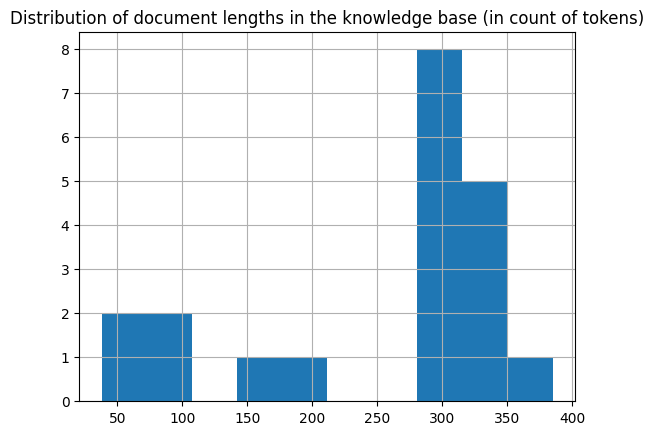

In [14]:
tokenizer = AutoTokenizer.from_pretrained("intfloat/e5-large-v2")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distrubution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()


In [15]:
# to empty gpu ram
import gc
torch.cuda.empty_cache()
gc.collect()

80

In [8]:
device = "cuda:0" if cuda.is_available() else "cpu"
model_name = "intfloat/e5-large-v2"

model_kwargs = {'device': device}

encode_kwargs = {'normalize_embeddings': True}

hf = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    multi_process='True',
    cache_folder="/home/sara/Documents/EmbeddingModel"
)

In [16]:
db = FAISS.from_documents(
    docs_processed, hf, distance_strategy=DistanceStrategy.COSINE
)

In [40]:
parser = StrOutputParser()
retriever= db.as_retriever()
llm = Ollama(model="mixtral:8x7b-instruct-v0.1-q6_K",num_gpu=2)
chain: Runnable = llm | parser
res=chain.invoke("what are the Newton's laws")

In [43]:
res


" Newton's laws of motion are three physical laws that form the foundation for classical mechanics. They describe the relationship between a body and the forces acting upon it, and its motion in response to those forces.\n\n1. The law of inertia: An object at rest tends to stay at rest, and an object in motion tends to stay in motion with the same speed and direction unless acted upon by an unbalanced force. This means that an object will not change its state of motion unless a net force is applied to it.\n2. The law of acceleration: The acceleration of an object is directly proportional to the net force acting on it and inversely proportional to its mass. Mathematically, this can be expressed as F = ma, where F is the net force, m is the mass of the object, and a is its acceleration.\n3. The law of action and reaction: For every action, there is an equal and opposite reaction. This means that when one object exerts a force on another object, the second object will experience an equal 